#  OSMnx overview: querying, simplifying, visualizing, saving 
# (sorgulama, basitleştirme, görselleştirme, kaydetme)

In [1]:
import geopandas as gpd
import osmnx as ox

%matplotlib inline
ox.__version__

'1.3.0'

In [2]:
# turn response caching off (yanıt önbelleğini kapat)
ox.settings.use_cache = False

# turn it back on and turn on/off logging to your console (tekrar açın ve konsolunuzda oturum açmayı açın/kapatın)
ox.settings.use_cache = True
ox.settings.log_console = False

# Part 1: get place boundaries from OpenStreetMap (OpenStreetMap'ten yer sınırlarını alın)

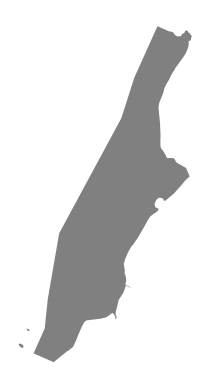

In [4]:
# get the boundary polygon for manhattan, project it, and plot it
# (manhattan için sınır poligonunu al, yansıt ve çiz)
city = ox.geocode_to_gdf("Manhattan, New York, USA")
city_proj = ox.project_gdf(city)
ax = city_proj.plot(fc="gray", ec="none")
_ = ax.axis("off")

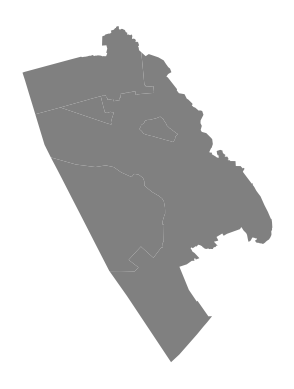

In [6]:
# get boundary polygons for several cities, save as GeoPackage, project to UTM, and plot
# (birkaç şehir için sınır poligonları alın, GeoPackage olarak kaydedin, UTM'ye yansıtın ve çizin)
place_names = [
    "Berkeley, California, USA",
    "Oakland, California, USA",
    "Piedmont, California, USA",
    "Emeryville, California, USA",
    "Alameda, Alameda County, CA, USA",
]
east_bay = ox.geocode_to_gdf(place_names)
east_bay.to_file("./data/east_bay.gpkg", driver="GPKG")
east_bay = ox.project_gdf(east_bay)
ax = east_bay.plot(fc="gray", ec="none")
_ = ax.axis("off")

In [8]:
# if you know the OSM ID of the place(s) you want, you can query it directly
# (İstediğiniz yer(ler)in OSM ID'sini biliyorsanız direk sorgulama yapabilirsiniz.)
ox.geocode_to_gdf(["R357794", "N8170768521", "W427818536"], by_osmid=True)

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance
0,"POLYGON ((135.55901 35.13689, 135.55907 35.136...",35.321221,34.874916,135.878442,135.559006,297921664,relation,357794,35.021041,135.755607,"Kyoto, Kyoto Prefecture, Japan",boundary,administrative,0.653138
1,POINT (13.38882 52.51699),52.521988,52.511988,13.393820,13.383820,82213219,node,8170768521,52.516988,13.388820,"Unter den Linden, Friedrichstraße, Dorotheenst...",railway,station,0.000010
2,"POLYGON ((-73.98141 40.76846, -73.98135 40.768...",40.800314,40.764745,-73.949606,-73.981408,202567746,way,427818536,40.782773,-73.965363,"Central Park, New York County, New York, Unite...",leisure,park,0.565172


# Part 2: download and model street networks

# Method #1, pass a bounding box

Bu, ağı tüm OSM düğümlerinden ve sınırlayıcı kutu içindeki yollardan oluşturur.

In [10]:
# define a bounding box in San Francisco
north, south, east, west = 37.79, 37.78, -122.41, -122.43

# create network from that bounding box
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")

# Method #2, pass a lat-lng point and bounding box distance in meters

Bu, noktanın n metre Kuzeyinde, Güneyinde, Doğusunda ve Batısında bir sınırlayıcı kutu oluşturur, ardından tüm OSM düğümlerinden ve sınırlayıcı kutu içindeki yollardan ağı oluşturur.

In [11]:
# define a point at the corner of California St and Mason St in SF
location_point = (37.791427, -122.410018)

# create network from point, inside bounding box of N, S, E, W each 750m from point
G = ox.graph_from_point(location_point, dist=750, dist_type="bbox", network_type="drive")

# Method #3, pass a lat-lng point and network distance in meters

Bu, noktanın n metre Kuzeyinde, Güneyinde, Doğusunda ve Batısında bir sınırlayıcı kutu oluşturur, ardından ağı tüm OSM düğümlerinden ve sınırlayıcı kutu içindeki yollardan oluşturur. Ardından, ağ boyunca noktadan n metreden daha uzaktaki tüm düğümleri kaldırarak ağı keser.

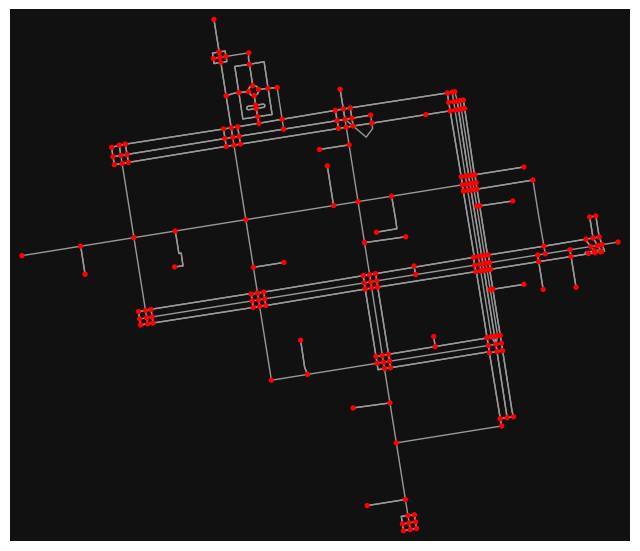

In [12]:
# same point again, but create network only of nodes within 500m along the network from point
G = ox.graph_from_point(location_point, dist=500, dist_type="network")
fig, ax = ox.plot_graph(G, node_color="r")

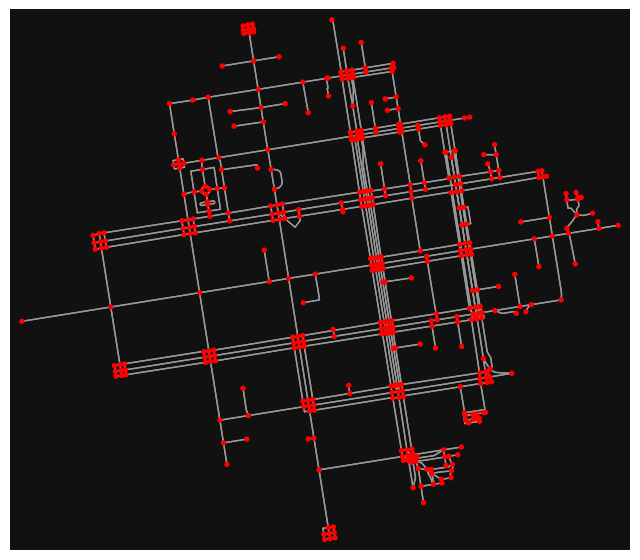

In [13]:
# create network only of nodes within 500m walking along the network from point
G = ox.graph_from_point(location_point, dist=500, dist_type="network", network_type="walk")
fig, ax = ox.plot_graph(G, node_color="r")

# Method #4, pass an address and distance (bounding box or network) in meters

Bu, adresi coğrafi olarak kodlar, bir sınırlayıcı kutu oluşturur, ağı indirir, ardından onu ağ mesafesine göre kısaltır (mesafe_type='network' ise).

In [15]:
# network from address, including only nodes within 1km along the network from the address
# (1km içindeki düğümleri içerir)
G = ox.graph_from_address(
    address="350 5th Ave, New York, NY",
    dist=1000,
    dist_type="network",
    network_type="drive",
)

# you can project the network to UTM (zone calculated automatically)
G_projected = ox.project_graph(G)

# Method #5, pass a place name

Bu, yer adını coğrafi olarak kodlar, yerin sınır şekli çokgenini ve sınırlayıcı kutusunu alır, sınırlayıcı kutu içindeki ağı indirir, ardından onu yerin sınır çokgenine kısaltır.

In [16]:
# create the street network within the city of Piedmont's borders
G = ox.graph_from_place("Piedmont, California, USA", network_type="drive")

In [17]:
# you can also pass multiple places as a mixed list of strings and/or dicts
places = [
    "Los Altos, California, USA",
    {"city": "Los Altos Hills", "state": "California"},
    "Loyola, California",
]
G = ox.graph_from_place(places, truncate_by_edge=True)

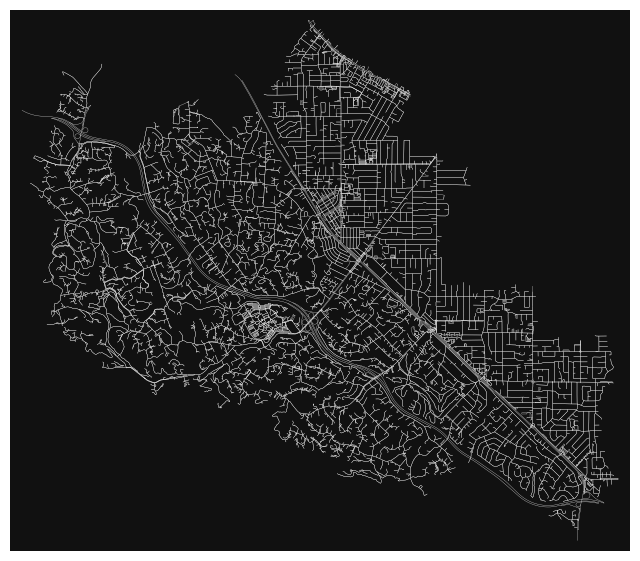

In [18]:
# save to disk as GeoPackage file then plot
ox.save_graph_geopackage(G)
fig, ax = ox.plot_graph(G, node_size=0, edge_color="w", edge_linewidth=0.2)

# Method #6, pass a polygon

Bu örnek, Görev Bölgesi'nin çokgenini bir şekil dosyasından yükler, ardından ağı sınırlayıcı kutusu içinde indirir, ardından yerin sınır çokgeninin dışında kalan tüm düğümleri budar.

In [20]:
calif = gpd.read_file("input_data/ZillowNeighborhoods-CA")
mission_district = calif[(calif["CITY"] == "San Francisco") & (calif["NAME"] == "Mission")]
polygon = mission_district["geometry"].iloc[0]

G2 = ox.graph_from_polygon(polygon, network_type="drive_service")

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "fiona\ogrext.pyx", line 136, in fiona.ogrext.gdal_open_vector
  File "fiona\_err.pyx", line 291, in fiona._err.exc_wrap_pointer
fiona._err.CPLE_OpenFailedError: input_data/ZillowNeighborhoods-CA: No such file or directory

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Monster\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Monster\AppData\Local\Temp\ipykernel_25592\743352085.py", line 1, in <module>
    calif = gpd.read_file("input_data/ZillowNeighborhoods-CA")
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Monster\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\io\file.py", line 259, in _read_file
    return _read_file_fiona(
           ^^^^^^^^^^^^^^^^^
  File "C:\Users\Monster\A

# Method #7, load a .osm xml file 

In [21]:
# create graph from .osm extract file
G = ox.graph_from_xml("./input_data/West-Oakland.osm.bz2")

FileNotFoundError: [Errno 2] No such file or directory: 'input_data\\West-Oakland.osm.bz2'

# Part 3: simplifying street network topology (sokak ağı topolojisini basitleştirme)

In [22]:
# create a network around some (lat, lng) point but do not simplify it yet
# (bazı (lat, lng) noktaları etrafında bir ağ oluştur ama henüz basitleştirme yapılmadı)
location_point = (33.299896, -111.831638)
G = ox.graph_from_point(location_point, network_type="drive_service", dist=500, simplify=False)

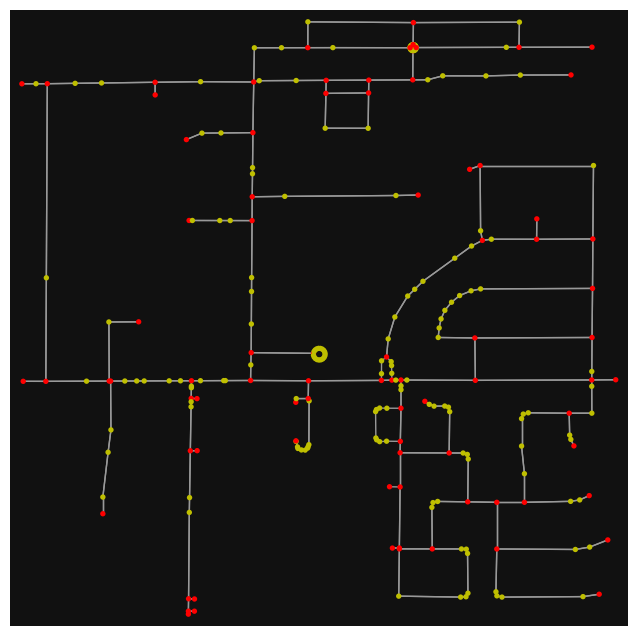

In [23]:
# turn off strict mode and see what nodes we'd remove, in yellow
# (katı modu kapatın ve hangi düğümleri kaldıracağımızı sarı renkte görün)
nc = ["r" if ox.simplification._is_endpoint(G, node) else "y" for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc)

Yukarıdaki noktalar OSM düğümleridir. Gerçek ağ düğümleri (kavşaklar/çıkmazlar) olmadıkları için sarı renkli düğümleri kaldıracağız.

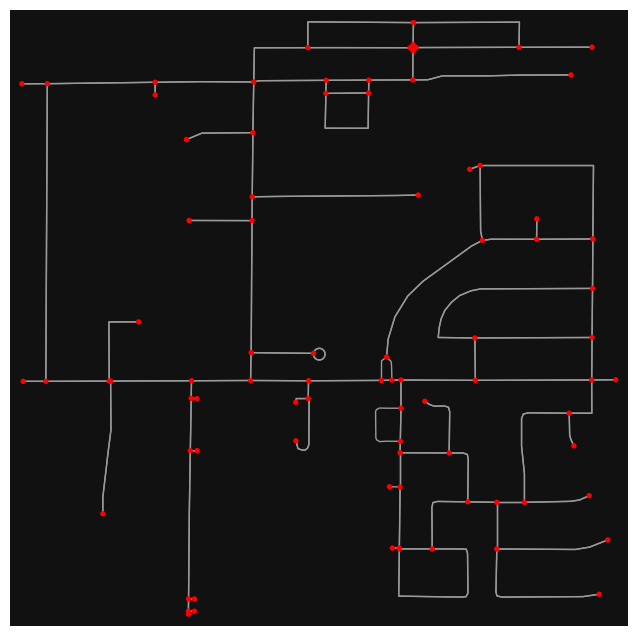

In [24]:
# simplify the network
G = ox.simplify_graph(G)
fig, ax = ox.plot_graph(G, node_color="r")

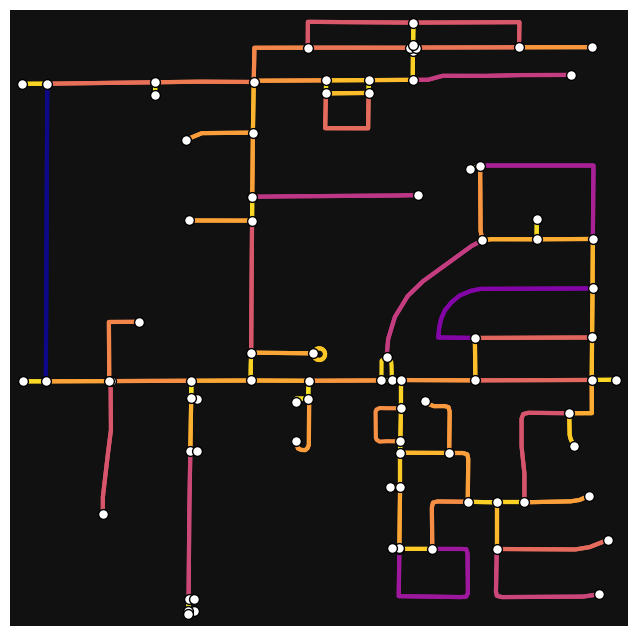

In [25]:
# show the simplified network with edges colored by length
ec = ox.plot.get_edge_colors_by_attr(G, attr="length", cmap="plasma_r")
fig, ax = ox.plot_graph(
    G, node_color="w", node_edgecolor="k", node_size=50, edge_color=ec, edge_linewidth=3
)

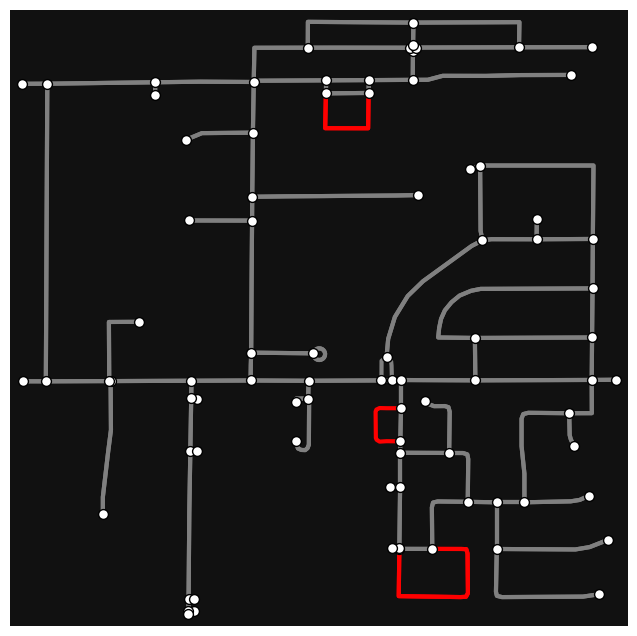

In [26]:
# highlight all parallel (multiple) edges
ec = ["gray" if k == 0 or u == v else "r" for u, v, k in G.edges(keys=True)]
fig, ax = ox.plot_graph(
    G, node_color="w", node_edgecolor="k", node_size=50, edge_color=ec, edge_linewidth=3
)

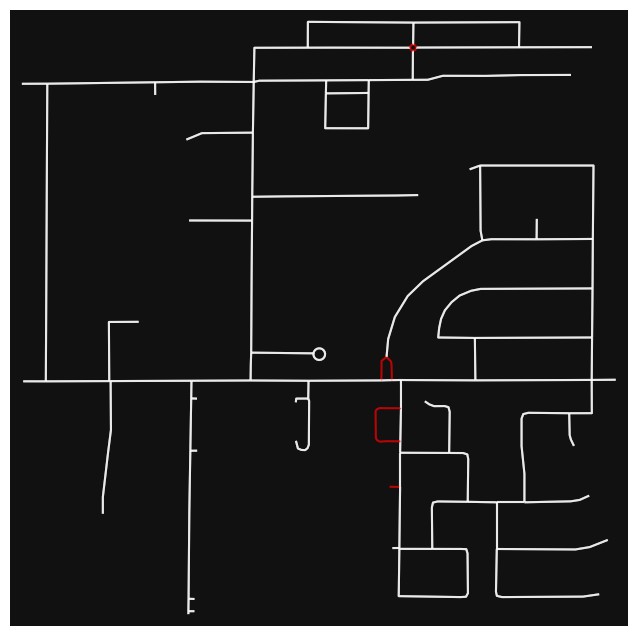

In [30]:
# highlight all one-way edges in the mission district network from earlier
ec = ["r" if data["oneway"] else "w" for u, v, key, data in G.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(G, node_size=0, edge_color=ec, edge_linewidth=1.5, edge_alpha=0.7)

# Part 4: saving networks to disk

In [31]:
# save street network as GeoPackage to work with in GIS
ox.save_graph_geopackage(G, filepath="./data/network.gpkg")

In [32]:
# save street network as GraphML file to work with later in OSMnx or networkx or gephi
ox.save_graphml(G, filepath="./data/network.graphml")

# Part 5: calculate basic network indicators 

In [34]:
# calculate basic street network metrics and display average circuity
stats = ox.basic_stats(G)
stats["circuity_avg"]

1.1358685392173113